# **Выбор локации для нефтяной скважины**

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## **Введение:**



### *Описание проекта:*
    Изучим пробы нефти в трех регионах, предоставленные компанией. Построим модель для определения региона, где добыча нефти принесет большую прибыль.
### *Цель проекта:*
    Выбрать локацию для скважин, которая принесет большую прибыль и меньшие убытки.
### *Описание данных:*
    Данные в трех таблицах: geo_data_0, geo_data_1, geo_data_2:
        id — уникальный идентификатор скважины;
        f0, f1, f2 — три признака точек;
        product — объём запасов в скважине (тыс. баррелей);
### *План работы:*
        1. Загрузка данных, изучение общей информации.
        2. Предобработка данных: проверим аномальные значения, пропуски, дубликаты, типы данных
        3. Исследовательский анализ данных: исследуем важные закономерности и сделаем выводы о необходимой подготовке данных.
        4. Подготовка данных: выполним подготовку признаков в пайплайне.
        5. Обучение и проверка модели для каждого региона:
            5.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.
            5.2. Обучим модель и сделаем предсказания на валидационной выборке.
            5.3. Сохраним предсказания и правильные ответы на валидационной выборке.
            5.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
            5.5. Проанализируем результаты. 
        6. Подготовка к расчёту прибыли:
            6.1. Все ключевые значения для расчётов сохраним в отдельных переменных.
            6.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в 
            каждом регионе. 
            6.3. Напишем выводы по этапу подготовки расчёта прибыли.
        7. Рассчет рисков и прибыли для каждого региона.
            7.1 Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
            7.2 Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
            7.3 Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков
        8. Общий вывод

In [1]:
# для корректного запуска
! pip install -q --upgrade scikit-learn
! pip install -q phik


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# База
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

# Анализ
from scipy.stats import shapiro, probplot, t
from phik.report import plot_correlation_matrix

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Подготовка данных + search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Модели
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Метрики
from sklearn.metrics import mean_squared_error, make_scorer

## ***Загрузка данных и изучение общей информации***

### Выгрузка данных

In [3]:
path_local = ('/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv')
flag = 1
for i in path_local:
    if not os.path.exists(i):
        flag = 0
        break
        
if flag:
    df_geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
else:
    df_geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    df_geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    df_geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
dict_df = {'Таблица geo_data_0': df_geo_data_0,
           'Таблица geo_data_1': df_geo_data_1,
           'Таблица geo_data_2': df_geo_data_2
          }
for key, value in dict_df.items():
    display(value.head().style.set_caption(key))
    print('\n')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В таблицах присутствуют все заявленные признаки. Названия столбцов в норме.

### Изучим общую информацию

In [5]:
for i in dict_df.values():
    display(i.info(), i.describe())
    print('\n'*2)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### ***Вывод:***
    - пропусков не наблюдается.
    - типы данных в норме.
    - все признаки присутствуют.


## ***Предобработка данных***

### Проверим данные на дубликаты


In [6]:
print('Явные дубликаты')
for key, value in dict_df.items():
    print(f'{key}: {value.duplicated().sum()}')

Явные дубликаты
Таблица geo_data_0: 0
Таблица geo_data_1: 0
Таблица geo_data_2: 0


Явных дубликатов не наблюдается

Проверим данные на наличие дубликатов по id

In [7]:
print('Дубликаты по id')
for key, value in dict_df.items():
    print(f'{key}: {value["id"].duplicated().sum()}')

Дубликаты по id
Таблица geo_data_0: 10
Таблица geo_data_1: 4
Таблица geo_data_2: 4


В таблице повторяются id, однако говорится, что id должен быть уникальным. Удалим повторяющиеся id и сразу установим id в качестве индексов таблиц.

In [8]:
df_geo_data_0 = df_geo_data_0.drop_duplicates('id').reset_index(drop=True).set_index('id')
df_geo_data_1 = df_geo_data_1.drop_duplicates('id').reset_index(drop=True).set_index('id')
df_geo_data_2 = df_geo_data_2.drop_duplicates('id').reset_index(drop=True).set_index('id')

### ***Вывод:***
- данные не содержат явных дубликатов
- данные содержали повторяющиеся id. Удалили их.
- пустых значений не обнаружено
- типы данных в норме

## ***Исследовательский анализ данных***

### Вспомогательные функции для анализа признаков

Главная функция построения графиков

In [9]:
def control_of_analysis_graphs(df_0, df_1, df_2, column, xlabel, title, shapiro_lab, \
                               bins=25, label=['geo_data_0', 'geo_data_1', 'geo_data_2']):
        
    hist_print(df_0, df_1, df_2, xlabel, bins, column, label, title)
    qqplot_print(df_0, df_1, df_2, column, xlabel, label)
    boxplot_print(df_0, df_1, df_2, column, label)
    shapiro_test(df_0, df_1, df_2, column, shapiro_lab)

Функция построения гистограммы

In [10]:
def hist_print(df_0, df_1, df_2, xlabel, bins, column, label, title):
    plt.figure(figsize=(15, 5));
    plt.suptitle(title, fontweight='bold', fontsize=16)
    sns.kdeplot(df_0[column], label=label[0])
    sns.kdeplot(df_1[column], label=label[1])
    sns.kdeplot(df_2[column], label=label[2])
    plt.legend()
    plt.grid()
    plt.title('Распределение значений')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('Плотность распределения', fontsize=13)
    plt.show()

Функция проведения теста Шапиро-Уилка

In [11]:
def shapiro_test(df_0, df_1, df_2, column, shapiro_lab):
    warnings.simplefilter("ignore", category=UserWarning)
    shapiro_result_0 = shapiro(df_0[column])
    shapiro_result_1 = shapiro(df_1[column])
    shapiro_result_2 = shapiro(df_2[column])
    
    if shapiro_result_0[1] >= 0.05:
        print(f'{shapiro_lab} в таблице geo_data_0 нормальное, p-значение = \
              {shapiro_result_0[1]}')
    else:
        print(f'{shapiro_lab} в таблице geo_data_0 не является нормальным, p-значение = \
              {shapiro_result_0[1]}' )
        
    if shapiro_result_1[1] >= 0.05:
        print(f'{shapiro_lab} в таблице geo_data_1 нормальное, p-значение = \
              {shapiro_result_1[1]}')
    else:
        print(f'{shapiro_lab} в таблице geo_data_1 не является нормальным, p-значение = \
              {shapiro_result_1[1]}' )
        
    if shapiro_result_2[1] >= 0.05:
        print(f'{shapiro_lab} в таблице geo_data_2 нормальное, p-значение = \
              {shapiro_result_2[1]}')
    else:
        print(f'{shapiro_lab} в таблице geo_data_2 не является нормальным, p-значение = \
              {shapiro_result_2[1]}' )
        warnings.resetwarnings()

Функция построения boxplot

In [12]:
def boxplot_print(df_0, df_1,  df_2, column, label):
    plt.figure(figsize=(15, 5));
    plt.subplot(1, 3, 1)
    df_0.boxplot(column);
    plt.title(label[0])
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    df_1.boxplot(column);
    plt.title(label[1])
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    df_2.boxplot(column);
    plt.title(label[2])
    plt.grid(True)
    plt.show()

Функция построения Q-Q plot

In [13]:
def qqplot_print(df_0, df_1, df_2, column, ylabel, label):
    plt.figure(figsize=(15, 5));
    plt.subplot(1, 3, 1)
    probplot(df_0[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[0])
    plt.xlabel('Теоретические квантили')
    
    plt.subplot(1, 3, 2)
    probplot(df_1[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[1])
    plt.xlabel('Теоретические квантили')
    
    plt.subplot(1, 3, 3)
    probplot(df_2[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[2])
    plt.xlabel('Теоретические квантили')
    plt.show()

### Анализ признаков

#### ***Первый признак (f0)***

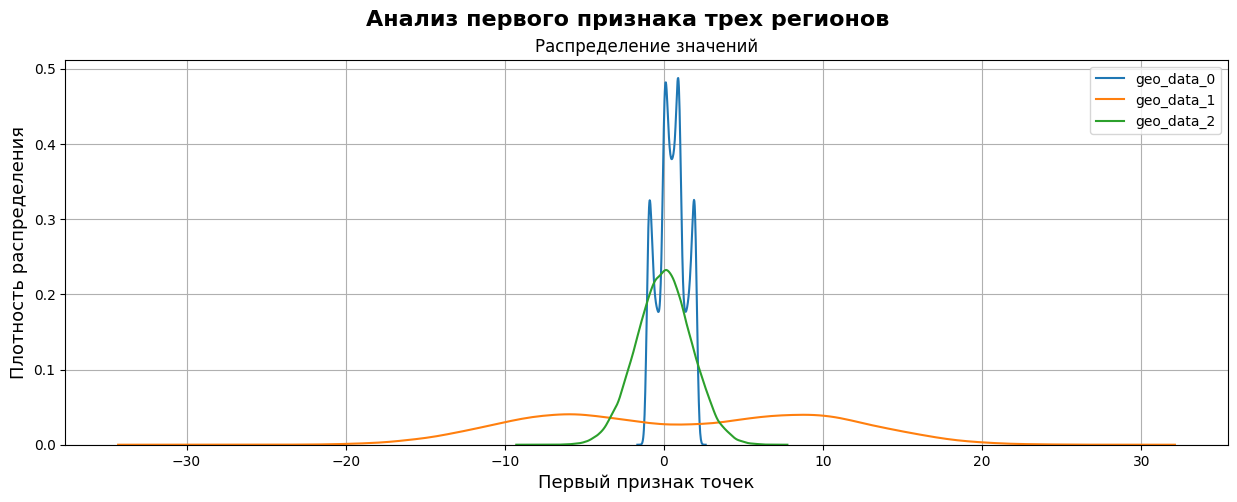

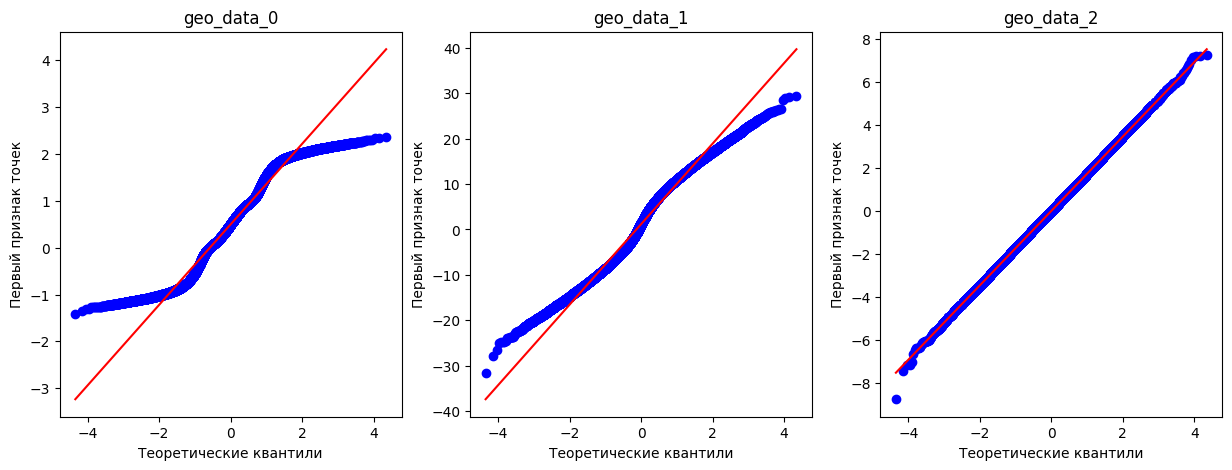

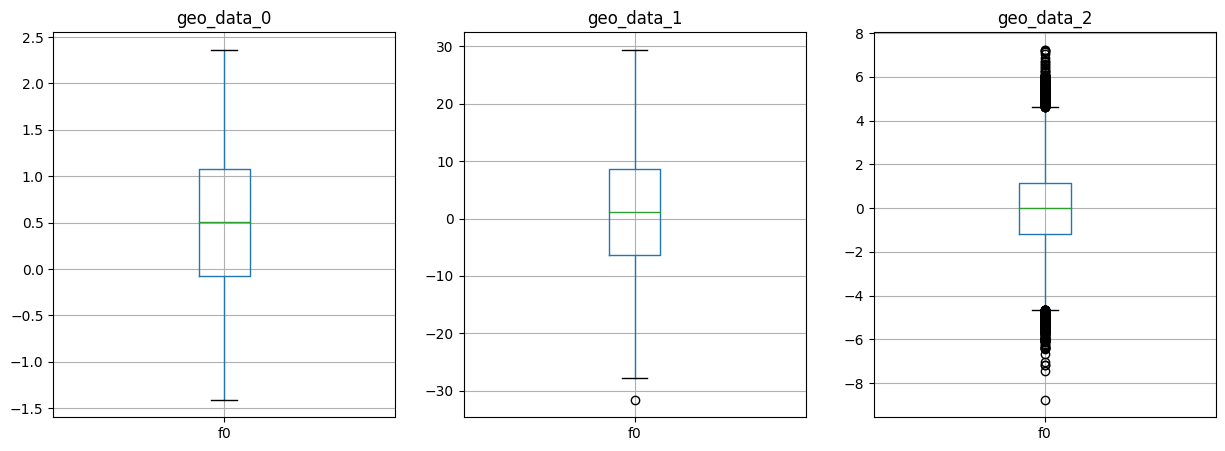

Распределение первого признака в таблице geo_data_0 не является нормальным, p-значение =               0.0
Распределение первого признака в таблице geo_data_1 не является нормальным, p-значение =               0.0
Распределение первого признака в таблице geo_data_2 нормальное, p-значение =               0.6502091884613037


In [14]:
control_of_analysis_graphs(df_geo_data_0, df_geo_data_1, df_geo_data_2, 'f0', \
                           'Первый признак точек', \
                           'Анализ первого признака трех регионов',
                          'Распределение первого признака')

По результатам теста Шапиро-Уилка, а так же глядя на гистограмму и Q-Q plot делаем вывод, что распределение первого признака в таблице geo_data_2 является нормальным, в отличии от распределений того же признака в таблицах geo_data_0 и geo_data_1. Наблюдаются выбросы в таблице geo_data_2, однако стоит их оставить, возможно они будут играть важную роль в определении лучшего региона.

Медианные значения:
- geo_data_0: ≈0.5
- geo_data_1: ≈2
- geo_data_1: ≈0

#### ***Второй признак (f1)***

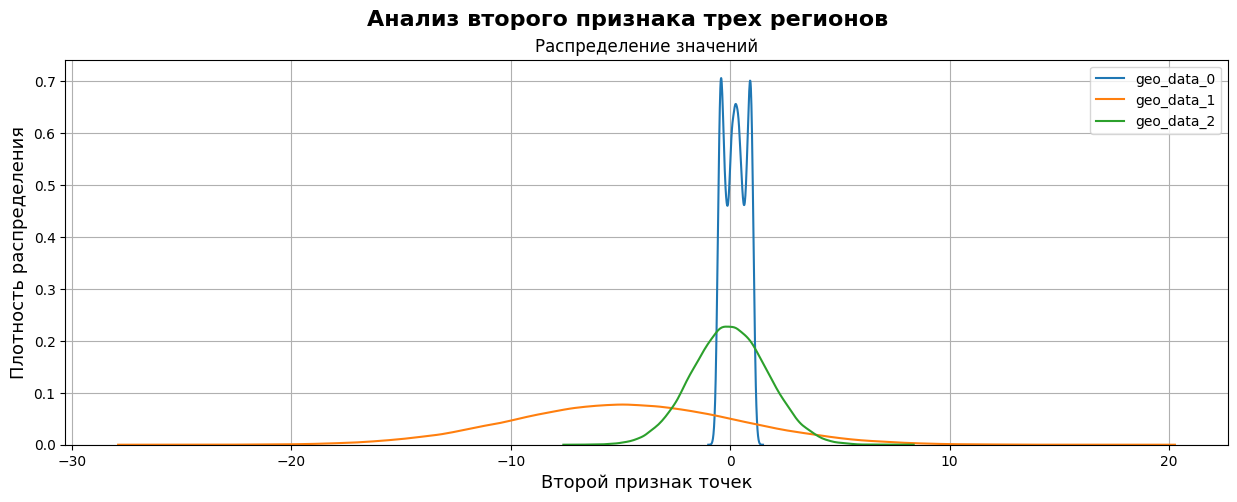

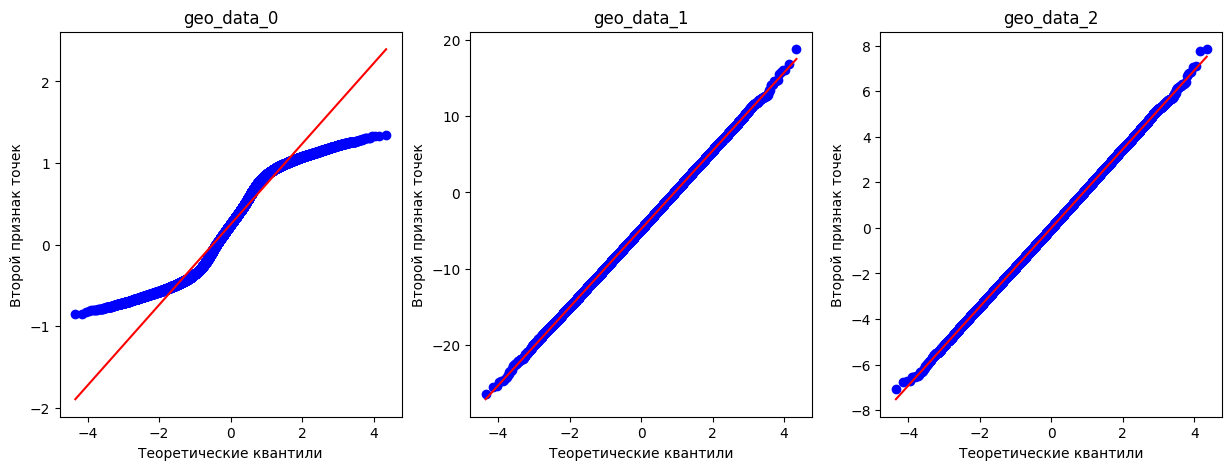

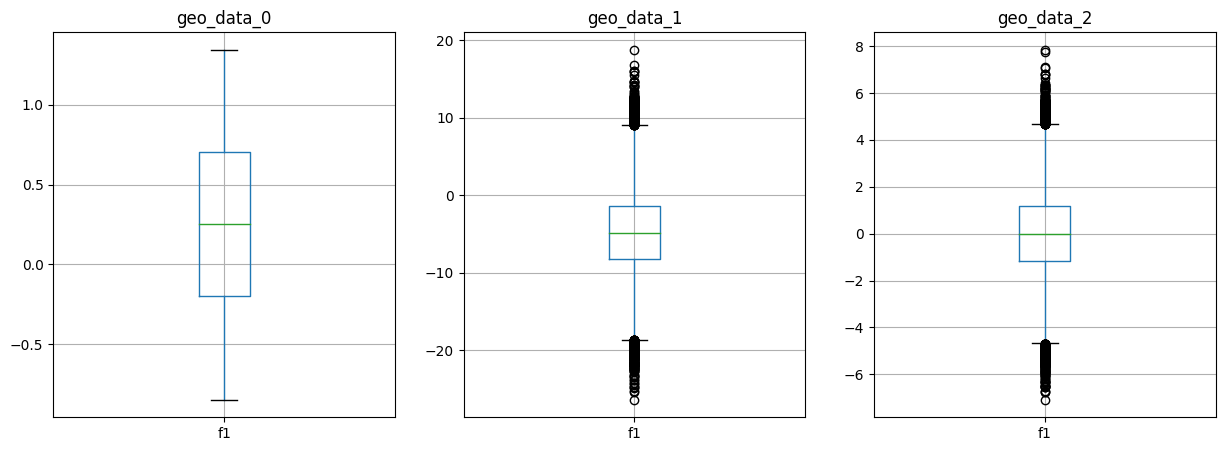

Распределение второго признака в таблице geo_data_0 не является нормальным, p-значение =               0.0
Распределение второго признака в таблице geo_data_1 нормальное, p-значение =               0.24989904463291168
Распределение второго признака в таблице geo_data_2 нормальное, p-значение =               0.9514608383178711


In [15]:
control_of_analysis_graphs(df_geo_data_0, df_geo_data_1, df_geo_data_2, 'f1', \
                           'Второй признак точек', \
                           'Анализ второго признака трех регионов',
                           'Распределение второго признака')

Можно точно сказать, что распределение второго признака в таблицах geo_data_1 и geo_data_2 являются нормальными, это видно и по результатам теста Шапиро-Уилка, и по гистограмме, и по Q-Q plot.
Второй признак в таблице geo_data_0 распределен ненормально. Наблюдаются выбросы в таблицах geo_data_0 и geo_data_2, но аномальных значений нет.

Медианные значения:
- geo_data_0: ≈0.25
- geo_data_1: ≈-5
- geo_data_1: ≈0

#### ***Третий признак (f2)***

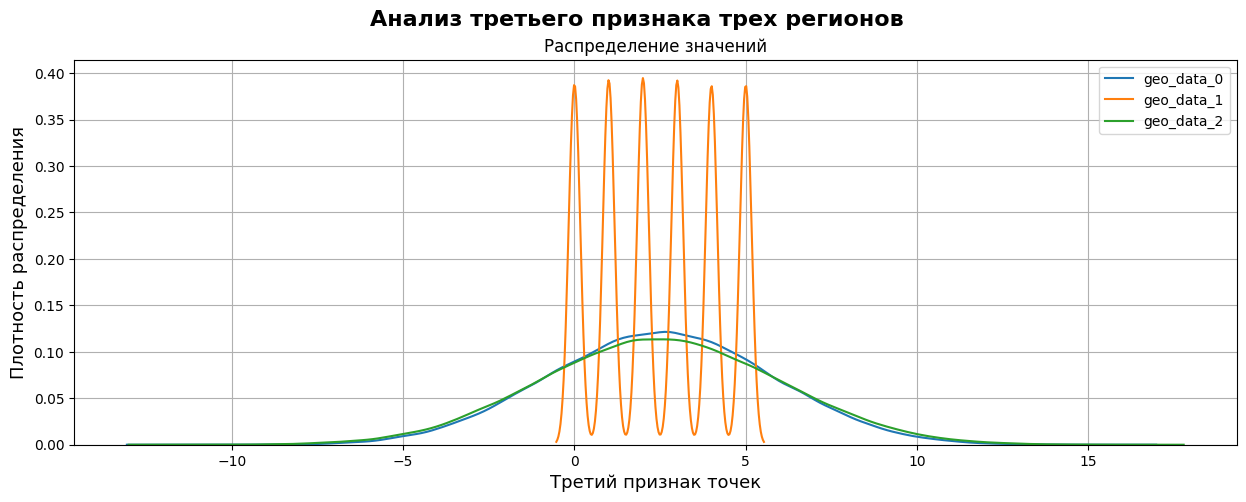

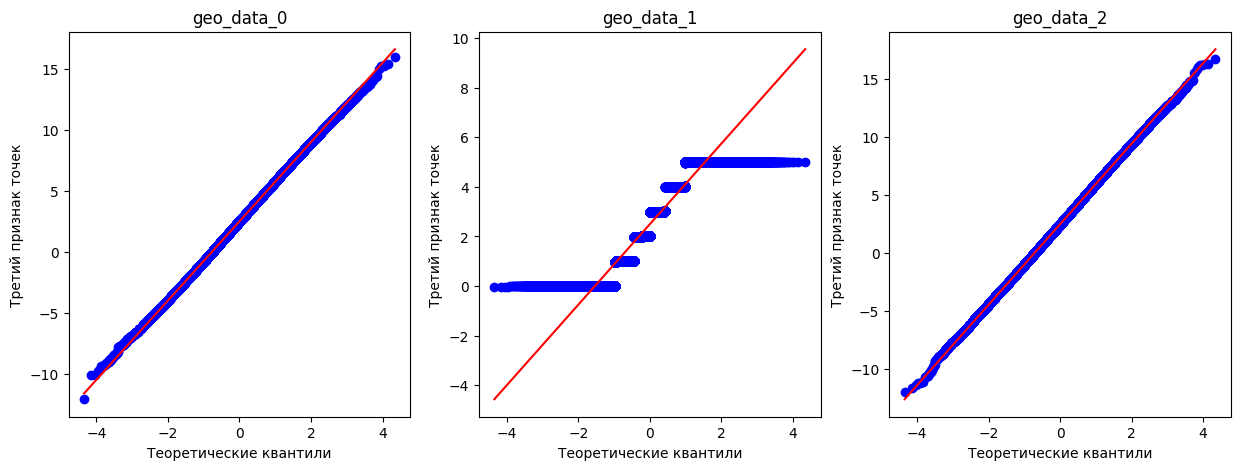

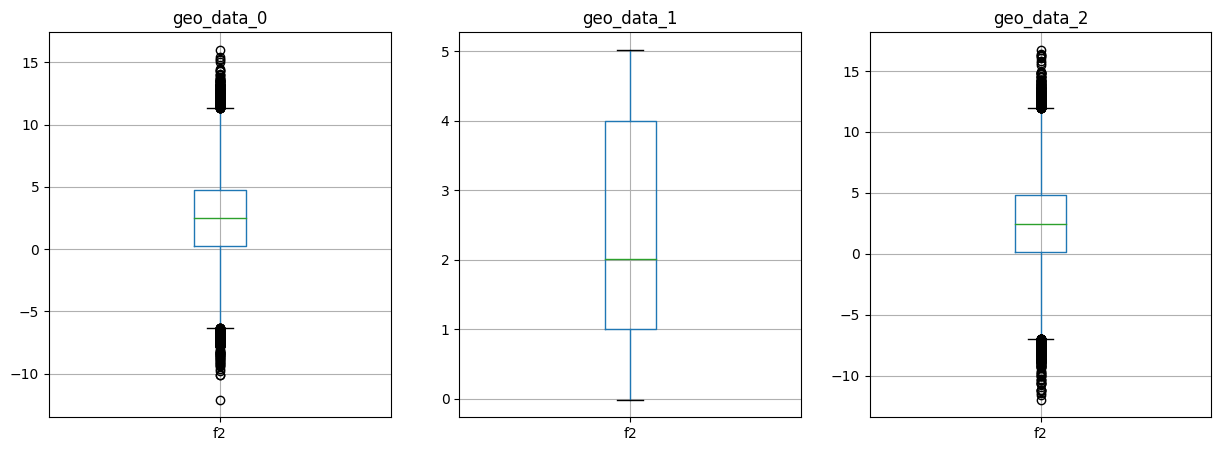

Распределение третьего признака в таблице geo_data_0 не является нормальным, p-значение =               8.207091923395637e-06
Распределение третьего признака в таблице geo_data_1 не является нормальным, p-значение =               0.0
Распределение третьего признака в таблице geo_data_2 не является нормальным, p-значение =               0.0033477351535111666


In [16]:
control_of_analysis_graphs(df_geo_data_0, df_geo_data_1, df_geo_data_2, 'f2', \
                           'Третий признак точек', \
                           'Анализ третьего признака трех регионов',
                          'Распределение третьего признака')

Глядя на гистограмму и Q-Q plot можем предположить, что третий признак в таблицах geo_data_0 и geo_data_2 распределен нормально, не смотря на результаты теста Шапиро-Уилка.
Третий признак в таблице geo_data_1 распределен ненормально. Наблюдаются выбросы в таблицах geo_data_0 и geo_data_2, но аномальных значений нет.

Медианные значения:
- geo_data_0: ≈2,5
- geo_data_1: ≈2
- geo_data_1: ≈2,5

#### ***Объем запасов в скважине***

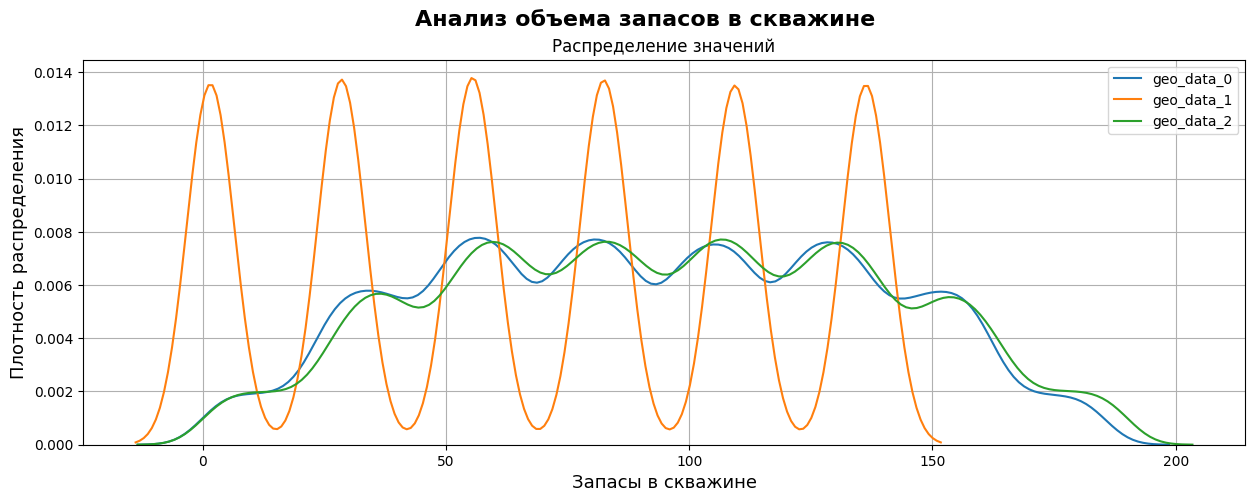

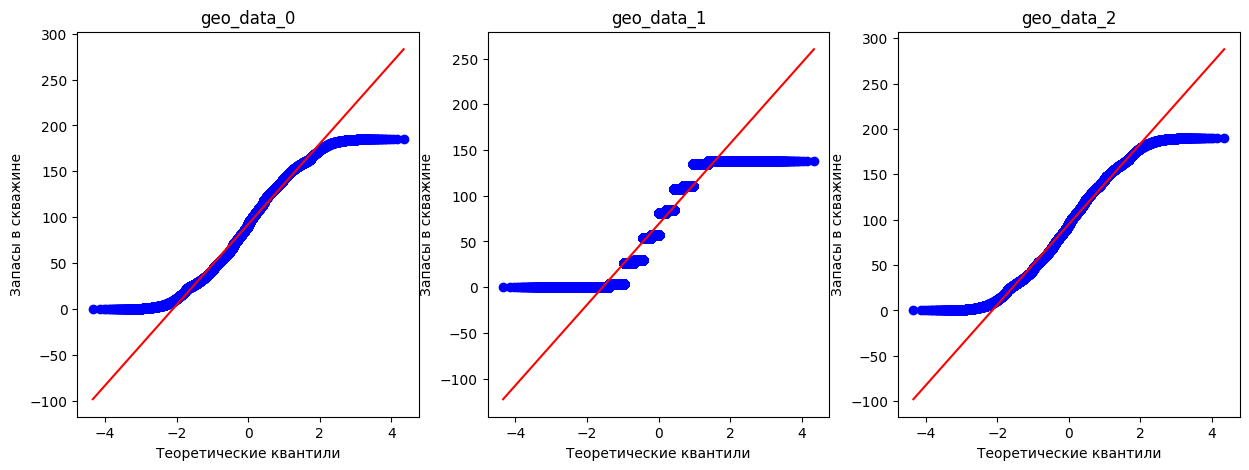

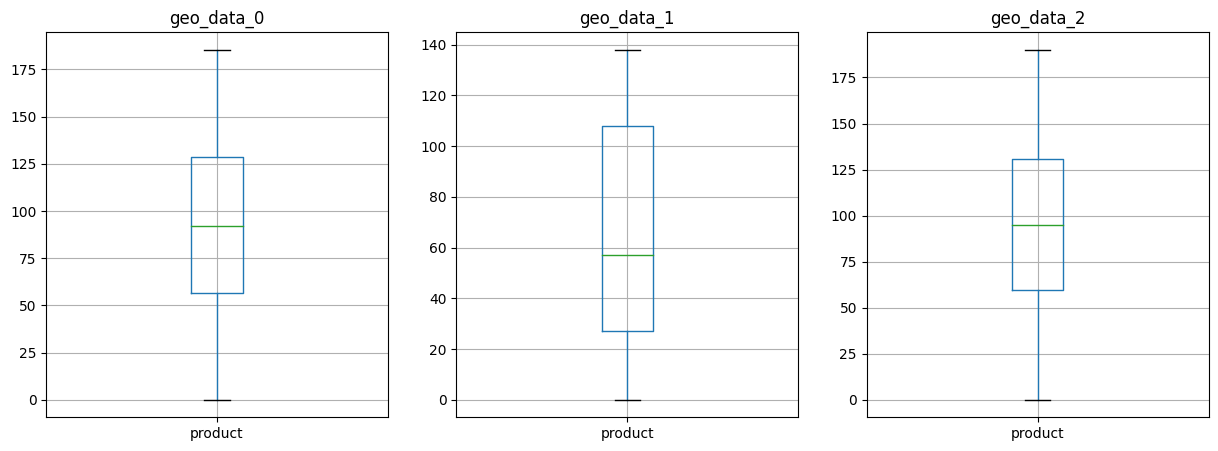

Распределение объема запаса в скважинах в таблице geo_data_0 не является нормальным, p-значение =               0.0
Распределение объема запаса в скважинах в таблице geo_data_1 не является нормальным, p-значение =               0.0
Распределение объема запаса в скважинах в таблице geo_data_2 не является нормальным, p-значение =               0.0


In [17]:
control_of_analysis_graphs(df_geo_data_0, df_geo_data_1, df_geo_data_2, 'product', \
                           'Запасы в скважине', \
                           'Анализ объема запасов в скважине',
                          'Распределение объема запаса в скважинах')

Все три распределения являются ненормальными.

Медианные значения:
- geo_data_0: ≈90
- geo_data_1: ≈59
- geo_data_1: ≈95

### Корреляционный анализ признаков

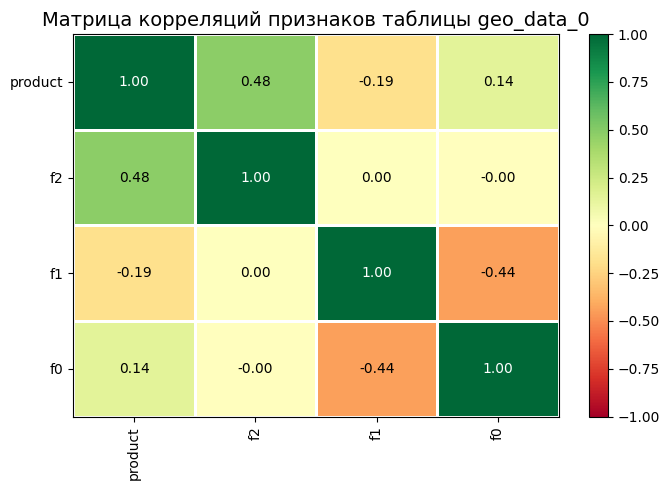

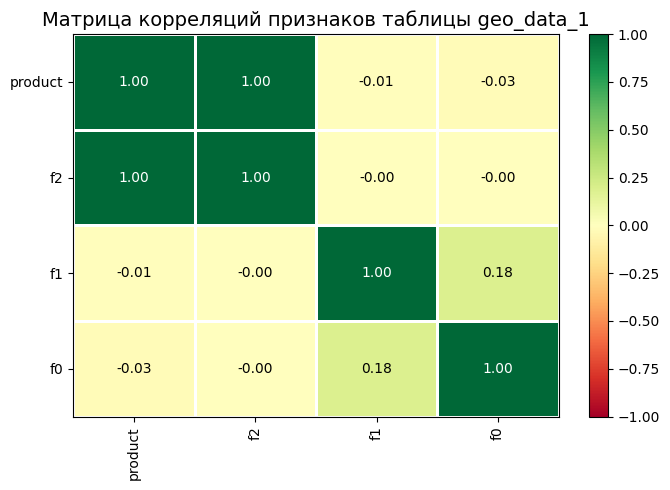

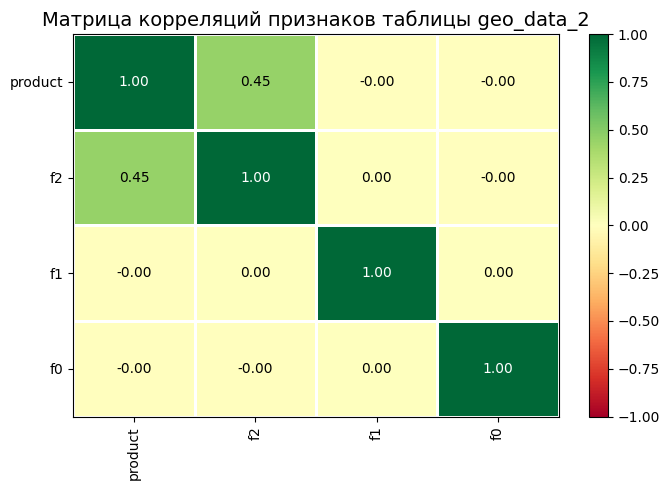

In [18]:
corr_matrix_0 = df_geo_data_0.corr()
corr_matrix_1 = df_geo_data_1.corr()
corr_matrix_2 = df_geo_data_2.corr()

plot_correlation_matrix(corr_matrix_0.values, 
                        x_labels=corr_matrix_0.columns, 
                        y_labels=corr_matrix_0.index, 
                        title='Матрица корреляций признаков таблицы geo_data_0', 
                        figsize=(7, 5))

plot_correlation_matrix(corr_matrix_1.values, 
                        x_labels=corr_matrix_1.columns, 
                        y_labels=corr_matrix_1.index, 
                        title='Матрица корреляций признаков таблицы geo_data_1', 
                        figsize=(7, 5))

plot_correlation_matrix(corr_matrix_2.values, 
                        x_labels=corr_matrix_2.columns, 
                        y_labels=corr_matrix_2.index, 
                        title='Матрица корреляций признаков таблицы geo_data_2', 
                        figsize=(7, 5))

1) таблица geo_data_0: 
    - целевой признак product сильнее всего коррелирует с признаком f2. Заметна небольшая корреляция с признаками f1 и f2.
    
2) таблица geo_data_1:
    - присутствует мультиколлинеарность между признаками f2 и product.
3) таблица geo_data_2:
    - прослеживается значительная корреляция между признаками f2 и product

### ***Вывод:***
    - исследовали все признаки из всех таблиц, для каждого региона в отдельности.
    - провели корреляционный анализ признаков. Выявили признаки, которые больше всего коррелируют с целевым признаком. Обнаружили мультиколлинеарность в таблице geo_data_1 между целевым признаком product и признаком f2.
    - можем сказать, что медианное значение объема запасов в скважинах больше в таблицах geo_data_0 и geo_data_2 (около 90-95). Медианное значение объема запасов в скважинах из таблицы geo_data_1 почти в полтора раза меньше (около 55-60).

## ***Подготовка данных***

Создаем обучающие и валидационные выборки в соотношении 75:25.

In [19]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

def preparation(df):
    return train_test_split(df.drop('product', axis=1), 
                                                        df['product'], 
                                                        test_size=TEST_SIZE, 
                                                        random_state=RANDOM_STATE)
train_val = {}
train_val['0'] = preparation(df_geo_data_0)
train_val['1'] = preparation(df_geo_data_1)
train_val['2'] = preparation(df_geo_data_2)

Создаем pipeline для подготовки данных

In [20]:
num_columns = ['f0', 'f1', 'f2']

num_pipe = Pipeline(
    [
        ('simpleImputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', StandardScaler())
    ]
)

Создаем общие пайплайны

In [21]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

Создаем пайплайн для перебора моделей и их гиперпараметров

In [22]:
param_grid = [
    
    {
        'model': [LinearRegression()],
        'preprocessor__num__scaler': ['passthrough']  
    },
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__alpha': [0.001 * 10**i for i in range(9)]
    },
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__alpha': [0.001 * 10**i for i in range(9)]
    }
]

### ***Вывод***
    Подготовили данные:
    - количественные признаки обрабатываем с помощью StandardScaler и MinMaxScaler
    - на всякий случай обрабатываем nan значения с помощью SimpleImputer
    - создали все необходимые пайплайны

## ***Обучение моделей для каждого региона***

Создаем метрику rmse для GridSearch

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

Находим лучшую модель с помощью GridSearchCV

In [24]:
search = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=scorer, n_jobs=-1)

Создаем словарь содержащий предсказания на валидационной выборке и правильные ответы по каждой таблице. Так же создаем таблицу содержащую средний запас предсказанного сырья и RMSE модели по каждой таблице.

In [25]:
predict_true = {}
mean_rmse = pd.DataFrame(columns=['mean_raw', 'RMSE'])

for i in range(3):
    search.fit(train_val[str(i)][0], train_val[str(i)][2])
    predict = search.predict(train_val[str(i)][1])
    
    predict_true[str(i)] = (pd
                            .DataFrame({'predict': predict, 'true': list(train_val[str(i)][3])})
                            .set_index(train_val[str(i)][3].index)
                           )
    
    mean_rmse.loc['region' + str(i)] = {'mean_raw': predict_true[str(i)]['predict'].mean(), 
                                     'RMSE': rmse(predict_true[str(i)]['true'], 
                                                  predict_true[str(i)]['predict'])}

In [26]:
mean_rmse

,mean_raw,RMSE
region0,92.609840,37.685089
region1,68.577035,0.892827
region2,94.935241,40.079864


Глядя на получившуюся таблицу, делаем вывод, что средний запас предсказанного сырья получился больше для первого и третьего регионов (примерно равный объем), а средний запас сырья для второго региона получился на 24-26 тыс. баррелей меньше. Однако стоит заметить, что показатель RMSE намного лучше именно для второго региона, это обуславливается сильной мультиколлинеарностью между признаками product и f2 в этой таблице.

### ***Вывод:***
- обучили и проверили модели для каждого региона
- получили предсказания объема запасов в скважинах на валидационной выборке 
- рассчитали средний запас предсказанного сырья для каждого региона и RMSE
- выяснили, что больший средний запас предсказан для 1 и 3 регионов, но с меньшей точностью, а для 2-го региона средний запас получился меньше, однако с большей точностью

## ***Подготовка к расчету прибыли***

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины.

In [27]:
# Количество скважин для разработки
N_WELLS = 200

# Доход с каждой единицы продукта
INCOME = 450_000

# Бюджет на разработку
BUDGET = 10**10

# Стоимость одной скважины
COST_WELL = BUDGET / N_WELLS


# Достаточный объем сырья
VOLUM_RAW = COST_WELL / INCOME

VOLUM_RAW

111.11111111111111

In [28]:
mean_rmse['mean_raw']

region0    92.609840
region1    68.577035
region2    94.935241
Name: mean_raw, dtype: float64

Средний запас в каждом регионе меньше, чем достаточный объем сырья для безубыточной разработки новой скважины. Это значит, что нужно отобрать только наилучшие скважины из представленных в таблице, у которых предсказанный запас будет выше, чем 111.111.

### ***Вывод:***
- рассчитали достаточный объем сырья для безубыточной разработки новой скважины, получили 111.1111
- поняли, что средний запас в каждом регионе меньше, чем достаточный объем сырья.

## ***Рассчет рисков и прибыли для каждого региона***

### Создаем функцию для рассчета прибыли по 200 скважинам

In [29]:
N_POINTS = 500
N_BETTER_POINTS = 200

In [30]:
def revenue(val):
    val_sorted = val.sort_values('predict', ascending=False).head(N_BETTER_POINTS)
    return val_sorted['true'].sum() * INCOME - BUDGET

### Применяем технику bootstrap для каждого региона и находим среднюю прибыль, 95% доверительный интервал и риск убытков

In [31]:
state = np.random.RandomState(12345)
BIL = 10**6
boot_results = pd.DataFrame(columns=['mean_income (mln)', 
                                     'lower_interval (mln)', 
                                     'upper_intreval (mln)', 'risk'])

for i in range(3):
    val_list = []
    
    for _ in range(1000):
        val = predict_true[str(i)].sample(n=N_POINTS, replace=True, random_state=state)
        val_list.append(revenue(val))
        
    val_list = pd.Series(val_list)
    boot_results .loc['region' + str(i)] = {'mean_income (mln)': val_list.mean() / BIL, 
                                 'lower_interval (mln)': val_list.quantile(0.025) / BIL, 
                                 'upper_intreval (mln)': val_list.quantile(0.975) / BIL,
                                           'risk': round(val_list[val_list < 0].count() / 1000 * 100, 2)}

In [32]:
boot_results 

,mean_income (mln),lower_interval (mln),upper_intreval (mln),risk
region0,417.354353,-96.261928,933.493095,5.9
region1,435.439669,25.316237,832.287543,1.9
region2,355.337569,-204.993087,880.169140,9.6


Самая большая средняя прибыль получилась со второго региона (region1), так же доверительный интервал для второго региона нижней границей не уходит в отрицательные значения, это значит, что с вероятностью 95% получившаяся прибыль будет положительной и попадать в интервал от 25 миллионов до 832 миллионов. Более того, риски связанные со вторым регионом так же значительно меньше по сравнению с двумя другими регионами. Все вышесказанное наводит нас на необходимость выбора второго региона (region1) для добычи нефти. Выбрав этот регион, можно получить в среднем больше прибыли с меньшими рисками.

### ***Вывод:***
- применив технику bootstrap нашли среднюю прибыль, 95% доверительный интервал и риск убытков для каждого региона
- изучив получившиеся данные, пришли к выводу о необходимости выбора второго региона в качестве подходящего для добычи нефти с большей выгодой и меньшими рисками

## **Общий вывод.**

    Главная задача:

        Выбрать локацию для скважин, которая принесет большую прибыль и меньшие убытки.
        
    Этапы работы:
        1. Загрузка данных, изучение общей информации.
        2. Предобработка данных: поработали с дубликатами, избавились от повторяющихся id в таблицах
        3. Исследовательский анализ данных: провели исследовательский и корреляционный анализ данных для каждой таблицы, заметили сильную мультиколлинеарность во второй таблице между признаками product и f2
        4. Подготовка данных: выполнили подготовку признаков с помощью SimpleImputer, StandartScaler, MinMaxScaler. Создали обучающие и валидационные выборки в соотношении 75:25.
        5. Обучение моделей: с помощью GridSearchCV подобрали модели для предсказания количества сырья. Нашли средний запас предсказанного сырья и RMSE моделей.
        6. Подготовка к рассчету прибыли: рассчитали достаточный объем сырья для безубыточной разработки новой скважины. Достаточный объем равен 111.111.
        7. Рассчет рисков и прибыли для каждого региона: создали функцию для рассчета прибыи и с помощью техники bootstrap нашли распределение прибыли. Рассчитали среднюю прибыль, 95% доверительный интервал и риск убытков для каждого региона.
        
***Вывод: необходимо выбрать второй регион, так как вероятность убытков в этом регионе меньше, чем на остальных регионах, и меньше чем 2,5%. Средняя прибыль на этом регионе так же больше по сравнению с остальными регионами. Плюс ко всему, 95% доверительный интервал захватывает только положительные значения.***